## Tu Dataset：MUTAG

### 导入数据

In [2]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


188张图，17个点，每个点7维特征，分类任务为2类。

邻接矩阵为稀疏矩阵，38个边。

下面将图分类2个集，150张用于训练，38张用于测试。

In [3]:
import torch

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


在 torch_geometricy.data.dataloader 类的帮助下，PyTorch Geometric自动地将多个图形批处理成一个巨大的图形

In [4]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



### 可视化部分
perplexity需要小于样本个数，这里选择10
`perplexity`是t-SNE中的一个重要参数，它影响算法的表现。它可以被看作是样本邻居的数量，通常建议的范围在5到50之间。


In [97]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE   # 降维

def visualize(h, color):
    # 数据维度太高画不出来，需要将数据降维至2维
    z = TSNE(n_components=2, perplexity=10).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color*10, cmap='Set2')
    plt.show()



### GNN网络

In [98]:
from torch.nn import Linear
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(123456)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. 获得节点嵌入
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)   # [batch_size, hidden_channels]

        # 3. 分类器
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)
# 输出结果

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### 绘制训练之前的数据图

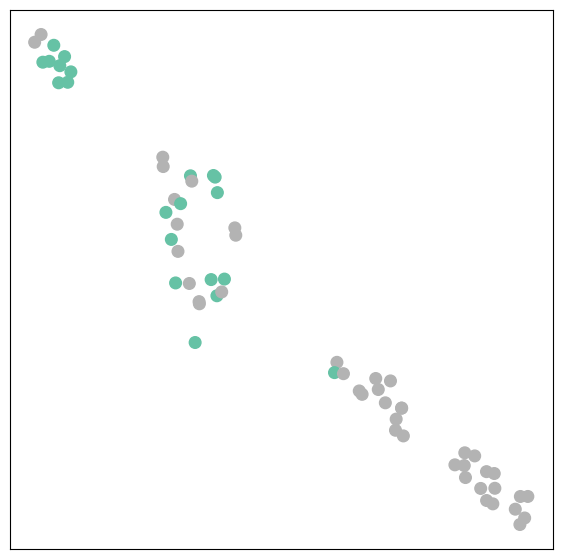

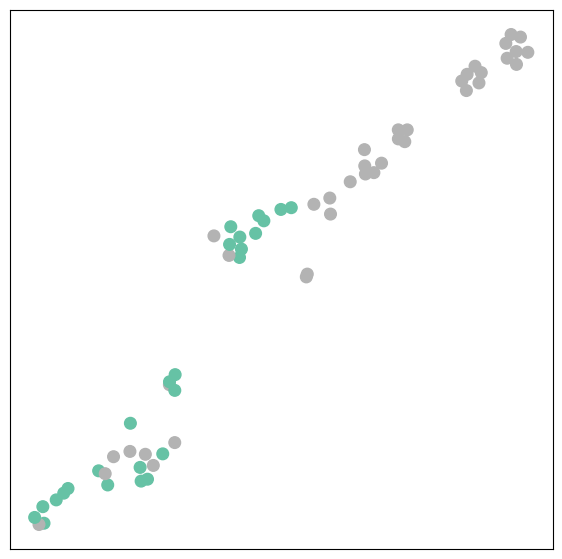

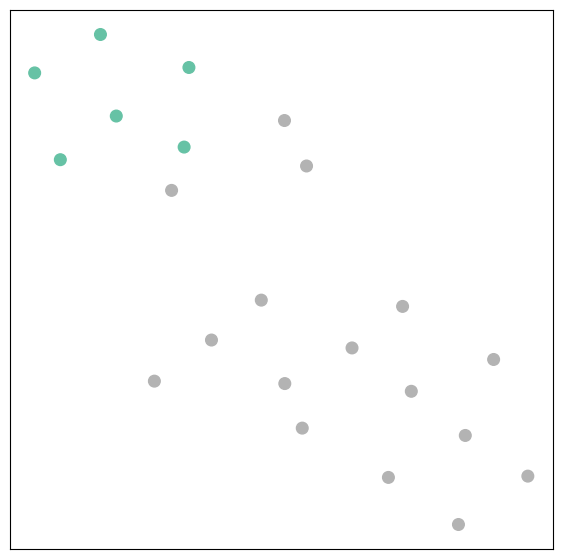

In [99]:
model.eval()
for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        visualize(out, color=data.y)

#### 训练和测试的函数

In [100]:
model = GNN(hidden_channels=64)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
    return loss

def test(loader):
    model.eval()
    test_corr = 0
    for data in loader:                            # 批遍历测试集数据集。
        out = model(data.x, data.edge_index, data.batch) # 一次前向传播
        pred = out.argmax(dim=1)                         # 使用概率最高的类别
        test_corr += int((pred == data.y).sum())
    test_acc = test_corr / (len(loader.dataset))# 检查真实标签
    return test_acc

#### 进行训练

In [101]:
from tqdm import *
loss_list = []
accuracy_list  = []
for epoch in tqdm(range(1, 201)):
    loss = train()
    loss_list.append(loss.item())
    train_Acc = test(train_loader)
    accuracy_list.append(train_Acc)
    test_Acc = test(test_loader)

print(f'Epoch: {epoch:03d}, Train Acc: {train_Acc:.4f}, Test Acc: {test_Acc:.4f}, Loss: {loss:.4f}')

100%|██████████| 200/200 [00:17<00:00, 11.53it/s]

Epoch: 200, Train Acc: 0.9400, Test Acc: 0.7632, Loss: 0.3213


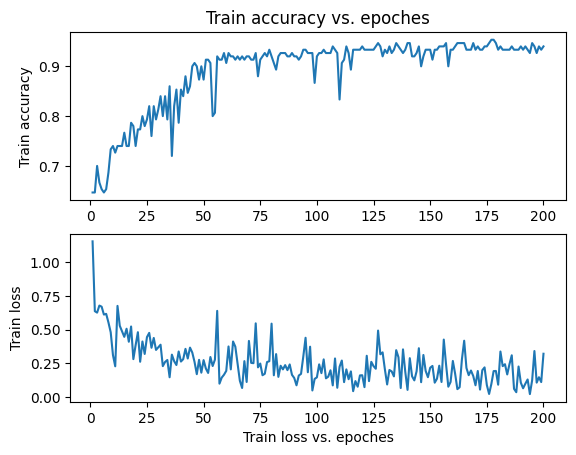

In [102]:
import matplotlib.pyplot as plt
x1 = range(1, 201)
x2 = range(1, 201)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1)
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.show()


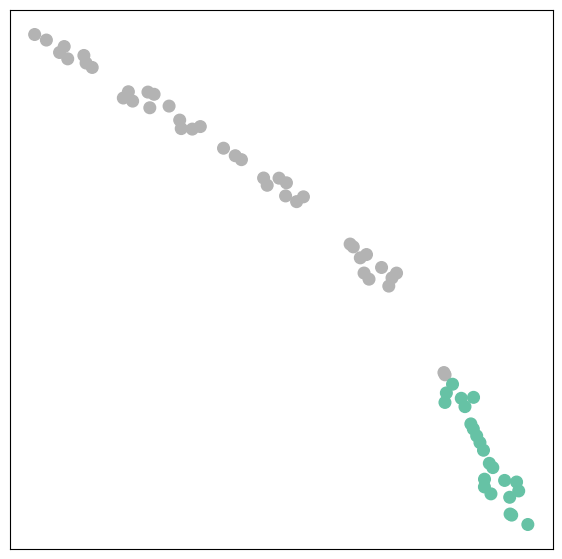

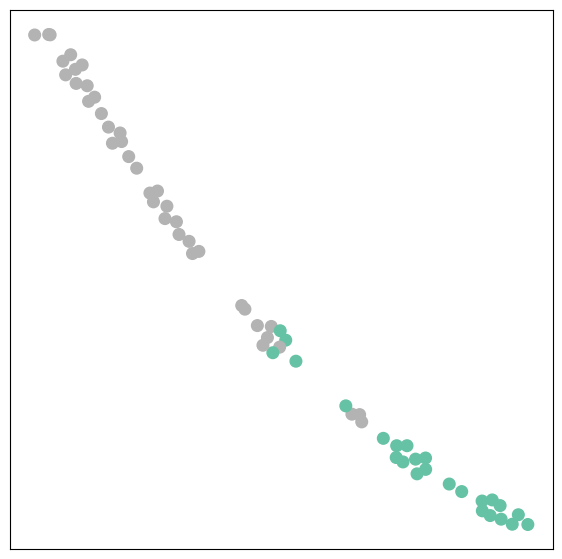

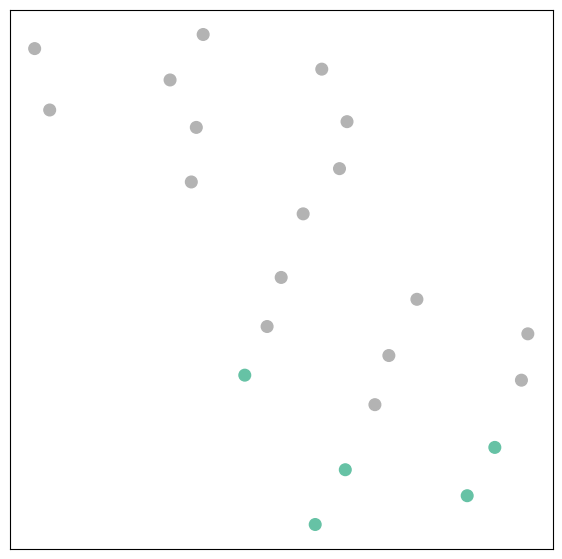

In [103]:
# model.eval()
for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        visualize(out, color=data.y)